In [62]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.optimize import minimize

df_ajustado = pd.read_csv("Datos/Transformados/limpio.csv", index_col=0)
df_ajustado.index = pd.to_datetime(df_ajustado.index)
rent_diarias = df_ajustado.pct_change()

1º OPCIÓN: Métricas

In [63]:
import itertools
import numpy as np
import pandas as pd

def generar_carteras(df_precios, risk_free_rate=0.0):
    returns = df_precios.pct_change().dropna()
    cov_anual = returns.cov() * 252
    corr_matrix = returns.corr(method='pearson')
    resultados = []
    combinaciones = list(itertools.combinations(df_precios.columns, 3))
    for activos in combinaciones:
        pesos = np.array([1/3, 1/3, 1/3])
        sub_returns = returns[list(activos)]
        port_daily_returns = sub_returns @ pesos

        # --- Métricas financieras ---
        rent_diaria_media = port_daily_returns.mean()
        rentabilidad_anualizada = (1 + rent_diaria_media) ** 252 - 1

        sub_cov = cov_anual.loc[list(activos), list(activos)]
        volatilidad_anualizada = np.sqrt(np.dot(pesos, np.dot(sub_cov, pesos.T)))

        rentabilidad_acumulada = (1 + port_daily_returns).prod() - 1

        sharpe = (rentabilidad_anualizada - risk_free_rate) / volatilidad_anualizada if volatilidad_anualizada > 0 else np.nan

        cumulative = (1 + port_daily_returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_dd = drawdown.min()

        # --- Correlaciones parciales ---
        c_ab = corr_matrix.loc[activos[0], activos[1]]
        c_ac = corr_matrix.loc[activos[0], activos[2]]
        c_bc = corr_matrix.loc[activos[1], activos[2]]
        corrs = [c_ab, c_ac, c_bc]
        corr_alta = max(corrs)
        idx_alta = corrs.index(corr_alta)
        pares = [(activos[0], activos[1]), (activos[0], activos[2]), (activos[1], activos[2])]
        par_alta = pares[idx_alta]
        tercero = list(set(activos) - set(par_alta))[0]
        corr_tercero_1 = corr_matrix.loc[tercero, par_alta[0]]
        corr_tercero_2 = corr_matrix.loc[tercero, par_alta[1]]
        corr_media_tercero = np.mean([corr_tercero_1, corr_tercero_2])
        score_corr = corr_alta - corr_media_tercero
        resultados.append({
            'cartera': activos,
            'rentabilidad_anualizada': float(rentabilidad_anualizada),
            'volatilidad_anualizada': float(volatilidad_anualizada),
            'rentabilidad_acumulada': float(rentabilidad_acumulada),
            'sharpe': float(sharpe),
            'drawdown_max': float(max_dd),
            'corr_mas_alta': float(corr_alta),
            'corr_media_tercero': float(corr_media_tercero),
            'score_corr': float(score_corr)
        })
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(
        by=['score_corr', 'rentabilidad_anualizada'],
        ascending=[False, False]
    ).reset_index(drop=True)
    return df_resultados

In [64]:
carteras = generar_carteras(df_ajustado)

In [65]:
carteras

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.364750,-0.282177,0.738265,0.246895,0.491370
1,"(GS, JPM, MMM)",0.268252,0.350003,0.512562,0.766428,-0.409218,0.849375,0.369843,0.479532
2,"(AXP, JPM, MMM)",0.236372,0.371785,0.399362,0.635776,-0.414738,0.845541,0.374648,0.470893
3,"(AXP, CRM, JPM)",0.293960,0.344340,0.594284,0.853691,-0.401152,0.845541,0.381124,0.464418
4,"(CRM, GS, JPM)",0.327319,0.323213,0.719605,1.012703,-0.377398,0.849375,0.390051,0.459325
...,...,...,...,...,...,...,...,...,...
2595,"(CRM, INTC, UNH)",0.229388,0.301998,0.458215,0.759569,-0.315196,0.412558,0.405754,0.006804
2596,"(AAPL, CAT, MRK)",0.323550,0.247666,0.797474,1.306399,-0.310737,0.377543,0.370837,0.006706
2597,"(INTC, PG, TRV)",0.135578,0.269052,0.237681,0.503911,-0.289201,0.442988,0.437668,0.005319
2598,"(KO, MRK, UNH)",0.153146,0.242894,0.303587,0.630506,-0.316621,0.525237,0.520335,0.004902


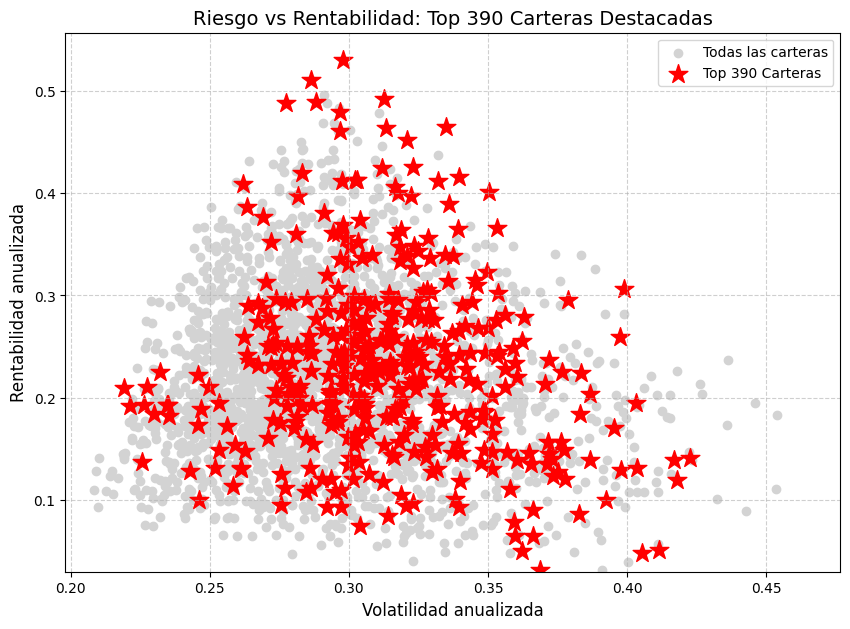

In [66]:
import matplotlib.pyplot as plt
top390 = carteras.head(390)

plt.figure(figsize=(10,7))
plt.scatter(carteras['volatilidad_anualizada'], carteras['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top390['volatilidad_anualizada'], top390['rentabilidad_anualizada'], 
            c='red', marker='*', s=200, label='Top 390 Carteras')

for i, row in top390.iterrows():
    activos = ', '.join(row['cartera'])
    

plt.xlim(carteras['volatilidad_anualizada'].min() * 0.95, carteras['volatilidad_anualizada'].max() * 1.05)
plt.ylim(carteras['rentabilidad_anualizada'].min() * 0.95, carteras['rentabilidad_anualizada'].max() * 1.05)


plt.title('Riesgo vs Rentabilidad: Top 390 Carteras Destacadas', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [67]:
top390

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.364750,-0.282177,0.738265,0.246895,0.491370
1,"(GS, JPM, MMM)",0.268252,0.350003,0.512562,0.766428,-0.409218,0.849375,0.369843,0.479532
2,"(AXP, JPM, MMM)",0.236372,0.371785,0.399362,0.635776,-0.414738,0.845541,0.374648,0.470893
3,"(AXP, CRM, JPM)",0.293960,0.344340,0.594284,0.853691,-0.401152,0.845541,0.381124,0.464418
4,"(CRM, GS, JPM)",0.327319,0.323213,0.719605,1.012703,-0.377398,0.849375,0.390051,0.459325
...,...,...,...,...,...,...,...,...,...
385,"(HD, MCD, MRK)",0.172747,0.245885,0.353159,0.702549,-0.303405,0.702387,0.479096,0.223291
386,"(BA, INTC, JPM)",0.128710,0.397788,0.100815,0.323564,-0.511083,0.669972,0.446907,0.223065
387,"(HD, KO, MMM)",0.181307,0.281453,0.346691,0.644183,-0.325101,0.563125,0.340068,0.223056
388,"(CAT, MCD, V)",0.235815,0.264158,0.514836,0.892704,-0.352473,0.706185,0.483182,0.223003


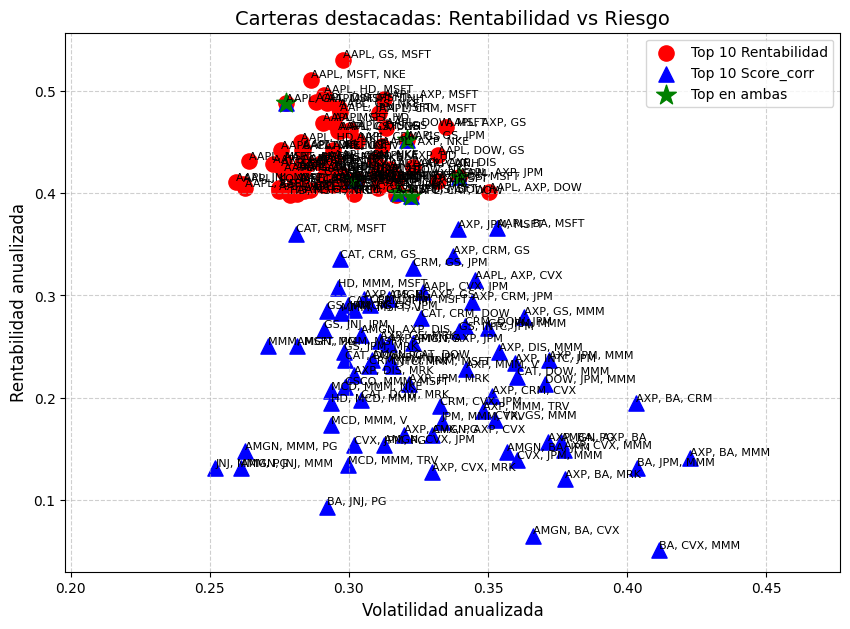

In [68]:
# --- Seleccionar los dos grupos de carteras ---
top_rent = carteras.nlargest(80, 'rentabilidad_anualizada')
top_score = carteras.nlargest(80, 'score_corr')
# Identificar coincidencias entre ambas selecciones
ids_comunes = top_rent.index.intersection(top_score.index)
# --- Crear figura ---
plt.figure(figsize=(10, 7))
# 🔴 Top 10 por rentabilidad
plt.scatter(top_rent['volatilidad_anualizada'], top_rent['rentabilidad_anualizada'],
            c='red', marker='o', s=120, label='Top 10 Rentabilidad')
# 🔵 Top 10 por score_corr
plt.scatter(top_score['volatilidad_anualizada'], top_score['rentabilidad_anualizada'],
            c='blue', marker='^', s=120, label='Top 10 Score_corr')
# 🟢 Coincidencias (carteras que están en ambos grupos)
if len(ids_comunes) > 0:
    coincidentes = carteras.loc[ids_comunes]
    plt.scatter(coincidentes['volatilidad_anualizada'], coincidentes['rentabilidad_anualizada'],
                c='green', marker='*', s=220, label='Top en ambas')
# --- Etiquetas con nombres de activos ---
for i, row in carteras.loc[top_rent.index.union(top_score.index)].iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'],
             activos, fontsize=8, ha='left', va='bottom')
# --- Estética del gráfico ---
plt.xlim(carteras['volatilidad_anualizada'].min() * 0.95, carteras['volatilidad_anualizada'].max() * 1.05)
plt.ylim(carteras['rentabilidad_anualizada'].min() * 0.95, carteras['rentabilidad_anualizada'].max() * 1.05)
plt.title('Carteras destacadas: Rentabilidad vs Riesgo', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

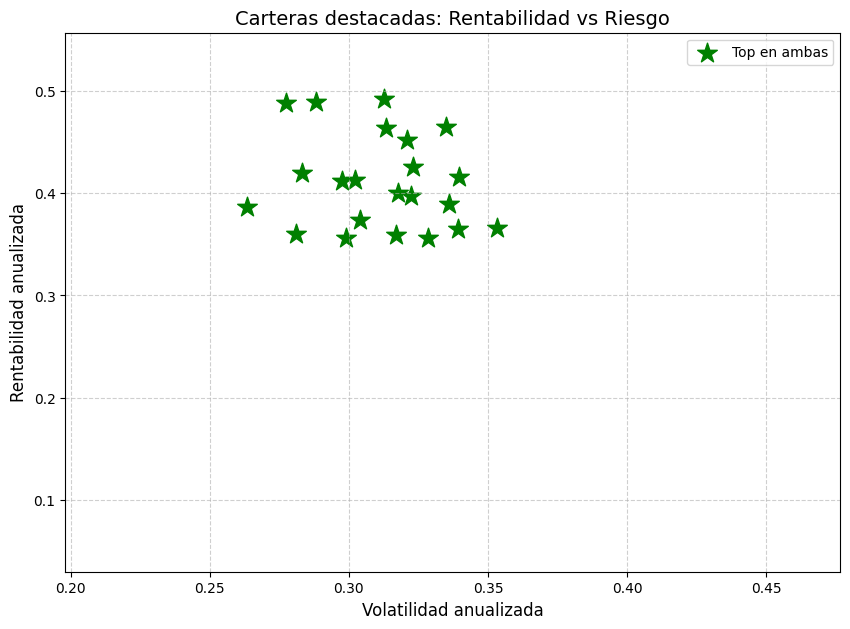

In [69]:
# --- Seleccionar los dos grupos de carteras ---
top_rent = carteras.nlargest(200, 'rentabilidad_anualizada')
top_score = carteras.nlargest(200, 'score_corr')
# Identificar coincidencias entre ambas selecciones
ids_comunes = top_rent.index.intersection(top_score.index)
# --- Crear figura ---
plt.figure(figsize=(10, 7))
# 🟢 Coincidencias (carteras que están en ambos grupos)
if len(ids_comunes) > 0:
    coincidentes = carteras.loc[ids_comunes]
    plt.scatter(coincidentes['volatilidad_anualizada'], coincidentes['rentabilidad_anualizada'],
                c='green', marker='*', s=220, label='Top en ambas')
# --- Etiquetas con nombres de activos ---
for i, row in carteras.loc[top_rent.index.union(top_score.index)].iterrows():
    activos = ', '.join(row['cartera'])
# --- Estética del gráfico ---
plt.xlim(carteras['volatilidad_anualizada'].min() * 0.95, carteras['volatilidad_anualizada'].max() * 1.05)
plt.ylim(carteras['rentabilidad_anualizada'].min() * 0.95, carteras['rentabilidad_anualizada'].max() * 1.05)
plt.title('Carteras destacadas: Rentabilidad vs Riesgo', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [70]:
coincidentes

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
180,"(AAPL, AXP, MSFT)",0.492211,0.312474,1.284822,1.575205,-0.363363,0.738265,0.460310,0.277955
142,"(AAPL, DIS, MSFT)",0.489441,0.288089,1.313271,1.698922,-0.324336,0.738265,0.444922,0.293342
47,"(AAPL, CAT, MSFT)",0.488446,0.277377,1.325639,1.760945,-0.303350,0.738265,0.384560,0.353704
107,"(AAPL, AXP, GS)",0.464773,0.334828,1.151035,1.388097,-0.413181,0.769597,0.459855,0.309742
82,"(AAPL, DOW, MSFT)",0.464274,0.313355,1.180799,1.481626,-0.371732,0.738265,0.413036,0.325229
28,"(AAPL, GS, JPM)",0.452221,0.320875,1.129208,1.409336,-0.394654,0.849375,0.466307,0.383068
140,"(AAPL, AXP, DIS)",0.425323,0.322993,1.036538,1.316819,-0.399650,0.702863,0.408763,0.294099
108,"(AAPL, MSFT, TRV)",0.420006,0.283197,1.072117,1.483088,-0.307371,0.738265,0.429668,0.308597
11,"(AAPL, AXP, JPM)",0.415735,0.339635,0.978247,1.224065,-0.411201,0.845541,0.427789,0.417752
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.364750,-0.282177,0.738265,0.246895,0.491370


2º OPCIÓN: Métricas Sharpe

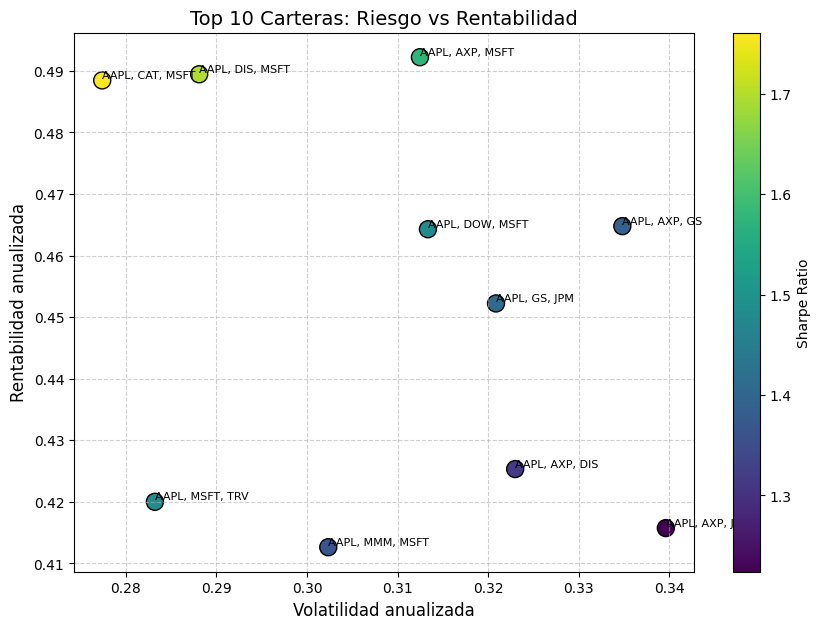

In [71]:
top10 = coincidentes.head(10)
plt.figure(figsize=(10,7))
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c=top10['sharpe'], cmap='viridis', s=150, edgecolor='black')
for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')
plt.title('Top 10 Carteras: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.colorbar(label='Sharpe Ratio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

3º OPCIÓN: Métricas Drawdown

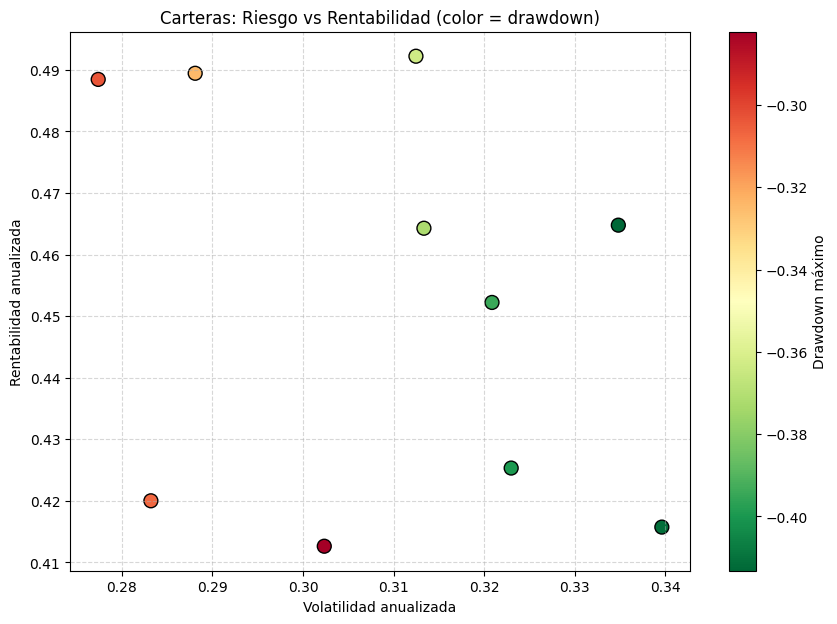

In [72]:
top10 = coincidentes.head(10)
plt.figure(figsize=(10,7))
plt.scatter(
    top10['volatilidad_anualizada'],
    top10['rentabilidad_anualizada'],
    c=top10['drawdown_max'],  
    cmap='RdYlGn_r',             
    s=100,
    edgecolor='black')
plt.colorbar(label='Drawdown máximo')
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Carteras: Riesgo vs Rentabilidad (color = drawdown)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

4º OPCIÓN: Métricas

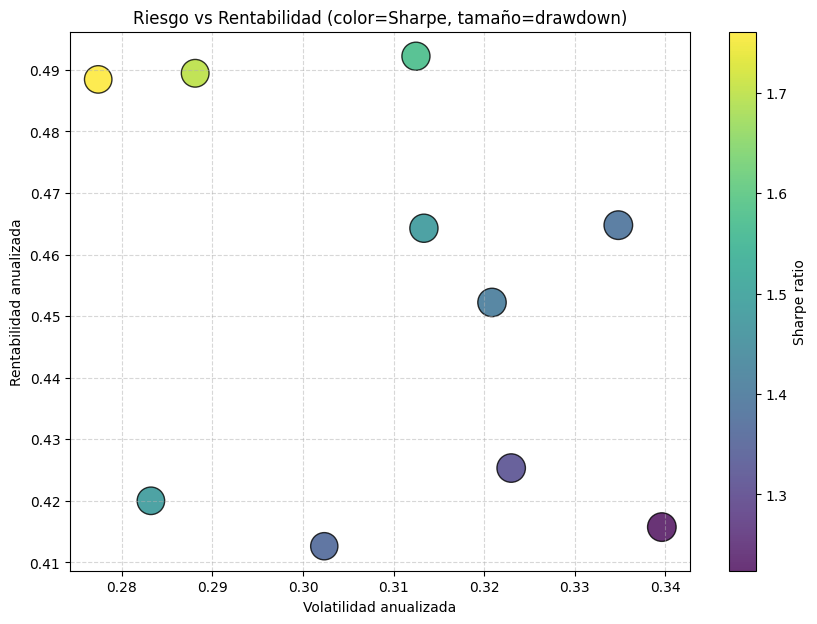

In [73]:
top10 = coincidentes.head(10)
plt.figure(figsize=(10,7))
plt.scatter(
    top10['volatilidad_anualizada'],
    top10['rentabilidad_anualizada'],
    c=top10['sharpe'],              
    s=(1 - top10['drawdown_max']) * 300,  
    cmap='viridis',
    edgecolor='black',
    alpha=0.8)
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Riesgo vs Rentabilidad (color=Sharpe, tamaño=drawdown)')
plt.colorbar(label='Sharpe ratio')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

5º OPCIÓN: Correlación (seleccion_de_cartera.ipynb)

In [74]:
cols_numericas = df_ajustado.select_dtypes(include=[np.number]).columns
df_pct = df_ajustado[cols_numericas].pct_change()

In [75]:
corr_matrix = df_pct.corr()
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)
diversificacion = corr_abs.sum().sort_values()
activos_diversificados = diversificacion.head(3).index.tolist()
print("Activos recomendados para diversificar:", activos_diversificados)

Activos recomendados para diversificar: ['MMM', 'CRM', 'PG']


6º OPCIÓN: Combinación de métricas + correlación

In [76]:
df_pct = df_ajustado.pct_change().dropna()
corr_matrix = df_pct.corr()
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)
diversificacion = corr_abs.sum().sort_values()
n_activos_diversificados = 18
activos_diversificados = diversificacion.head(n_activos_diversificados).index.tolist()
print("Activos más diversificados:", activos_diversificados)


Activos más diversificados: ['MMM', 'CRM', 'AMGN', 'MRK', 'INTC', 'PG', 'AAPL', 'JNJ', 'BA', 'NKE', 'CAT', 'DIS', 'UNH', 'DOW', 'TRV', 'CSCO', 'KO', 'MSFT']


In [77]:
import itertools
combinaciones = list(itertools.combinations(activos_diversificados, 3))
print(f"Se evaluarán {len(combinaciones)} combinaciones de 3 activos.")

Se evaluarán 816 combinaciones de 3 activos.


In [78]:
df_filtrado = df_ajustado[activos_diversificados]
carteras_filtradas = generar_carteras(df_filtrado)
top10 = carteras_filtradas.sort_values(by='sharpe', ascending=False).head(10)
top10

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
72,"(AAPL, NKE, MSFT)",0.511040,0.286404,1.394812,1.784329,-0.323536,0.738265,0.499359,0.238906
6,"(AAPL, CAT, MSFT)",0.488446,0.277377,1.325639,1.760945,-0.303350,0.738265,0.384560,0.353704
33,"(AAPL, DIS, MSFT)",0.489441,0.288089,1.313271,1.698922,-0.324336,0.738265,0.444922,0.293342
102,"(AAPL, UNH, MSFT)",0.488350,0.291991,1.302315,1.672480,-0.311882,0.738265,0.522443,0.215822
137,"(PG, AAPL, MSFT)",0.431398,0.263986,1.140603,1.634170,-0.265609,0.738265,0.539647,0.198618
645,"(AAPL, NKE, CAT)",0.442347,0.275756,1.162000,1.604121,-0.355465,0.489319,0.426090,0.063229
89,"(AAPL, JNJ, MSFT)",0.410818,0.259295,1.074851,1.584363,-0.278689,0.738265,0.516663,0.221602
51,"(AAPL, KO, MSFT)",0.409450,0.261935,1.065739,1.563171,-0.315646,0.738265,0.477809,0.260455
642,"(AAPL, NKE, DIS)",0.443311,0.283697,1.154723,1.562625,-0.365528,0.506297,0.442755,0.063542
780,"(AAPL, NKE, UNH)",0.442254,0.283145,1.150998,1.561933,-0.350141,0.497869,0.474663,0.023206


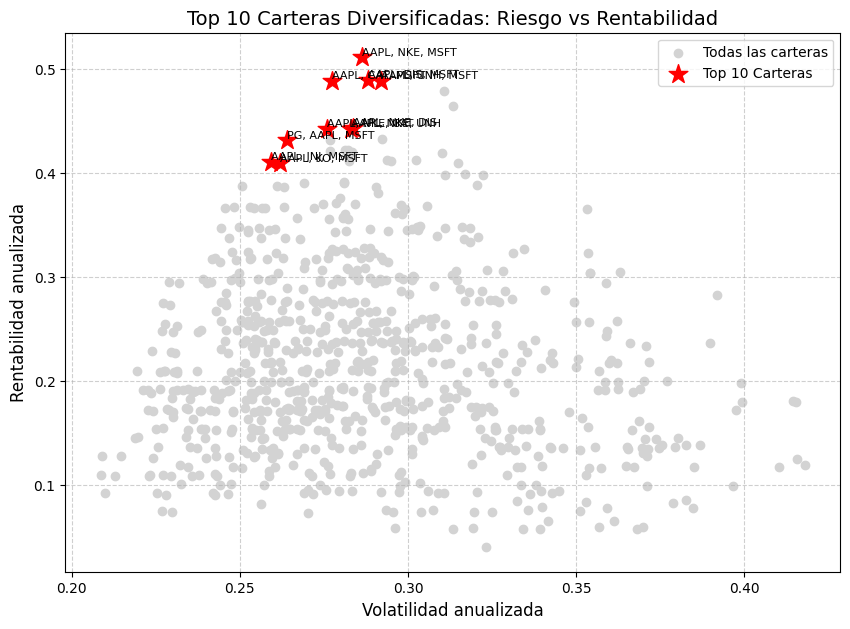

In [79]:
plt.figure(figsize=(10,7))
plt.scatter(carteras_filtradas['volatilidad_anualizada'], carteras_filtradas['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c='red', marker='*', s=200, label='Top 10 Carteras')
for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')
plt.title('Top 10 Carteras Diversificadas: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()